## Нейронные сети на исскуственных данных в июньском соревновании [Kaggle](https://www.kaggle.com/c/tabular-playground-series-jun-2021/overview) 

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 686kB 8.2MB/s 


 
## Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss

import gc

import matplotlib.pyplot as plt
import seaborn as sns

# библиотеки для работы с нейросетями
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

from keras.models import Model

## Метрика

In [ ]:
def custom_metric(y_true, y_pred): #multi-class logarithmic loss (по условию соревнования)
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = cce(y_true, y_pred)
    return loss

## Зегрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip '/content/gdrive/MyDrive/DL_LAMA_Kaggle/tabular-playground-series-jun-2021.zip'

Archive:  /content/gdrive/MyDrive/DL_LAMA_Kaggle/tabular-playground-series-jun-2021.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df_train = pd.read_csv('/content/train.csv').drop('id', axis = 1)
df_train['target'] = df_train['target'].str.slice(start=6).astype(int) - 1

y_train = df_train['target'].copy()
X_train = df_train.copy().drop('target', axis = 1)

X_test = pd.read_csv('/content/test.csv').drop('id', axis = 1)

In [ ]:
Y_train = to_categorical(y_train) # преобразование целого ряда в матрицу для keras
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
X_train.shape

(200000, 75)

In [ ]:
X_test.shape

(100000, 75)

In [ ]:
X_train.info()

In [ ]:
X_test.info()

## Анализ данных

In [ ]:
X_train.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000
mean,0.972710,1.168365,2.219325,2.296735,0.793530,1.431105,1.010695,0.673090,1.94398,1.719655,1.422550,0.980955,2.444760,1.078085,1.406445,1.413200,1.389720,0.317740,1.656610,6.186895,1.438510,1.031415,1.465935,0.572000,1.061165,2.348775,0.774490,0.789325,2.326190,1.581820,0.598825,1.856545,1.516105,1.556650,0.681135,1.162070,0.665375,1.500505,1.276080,2.332940,1.255005,1.159385,0.834600,4.472965,0.890300,0.690865,2.413920,0.969055,1.527270,0.479560,2.275075,1.617085,0.622570,1.354225,6.008040,2.493365,2.118190,0.566695,0.927100,1.343715,1.666660,1.287270,2.764225,1.455190,0.696915,1.798040,0.508695,1.827300,0.910370,1.603585,1.219210,0.806895,1.282925,2.94021,0.632005
std,3.941836,3.993407,6.476570,7.551858,2.935785,5.162746,3.949231,2.234949,3.93133,5.916988,3.288376,3.837771,3.421765,3.713650,2.868740,8.240441,3.056888,1.052619,2.557042,13.982531,2.666167,2.931762,6.734983,1.676326,5.718083,7.319992,1.752804,3.517043,8.402752,5.565404,1.418070,3.898896,7.782723,3.913513,2.307127,3.443417,2.637001,2.900480,4.268174,4.523171,4.482382,5.407836,3.496194,7.723795,2.150593,2.188692,9.774465,5.845938,4.375537,2.056233,5.227827,5.149637,1.953864,2.960980,11.286352,8.787684,4.107152,2.023164,2.697104,6.168400,6.387178,5.480586,8.251200,7.121127,2.185252,5.053014,1.867330,7.188924,3.835182,4.877679,4.826003,2.458741,4.261420,10.78465,3.925310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.

# Доля '0' в train 

In [ ]:
pd.DataFrame((X_train==0).sum()/len(X_train), columns=["zero_rate"])\
    .style.bar(subset=['zero_rate'], color='#20c8f2')

,zero_rate
feature_0,0.731945
feature_1,0.701875
feature_2,0.612505
feature_3,0.603835
feature_4,0.770465
feature_5,0.595100
feature_6,0.754845
feature_7,0.751750
feature_8,0.585000
feature_9,0.622330


# Распределение train и test выборки
видим что распределение похоже

Orange is train, and black is test data.


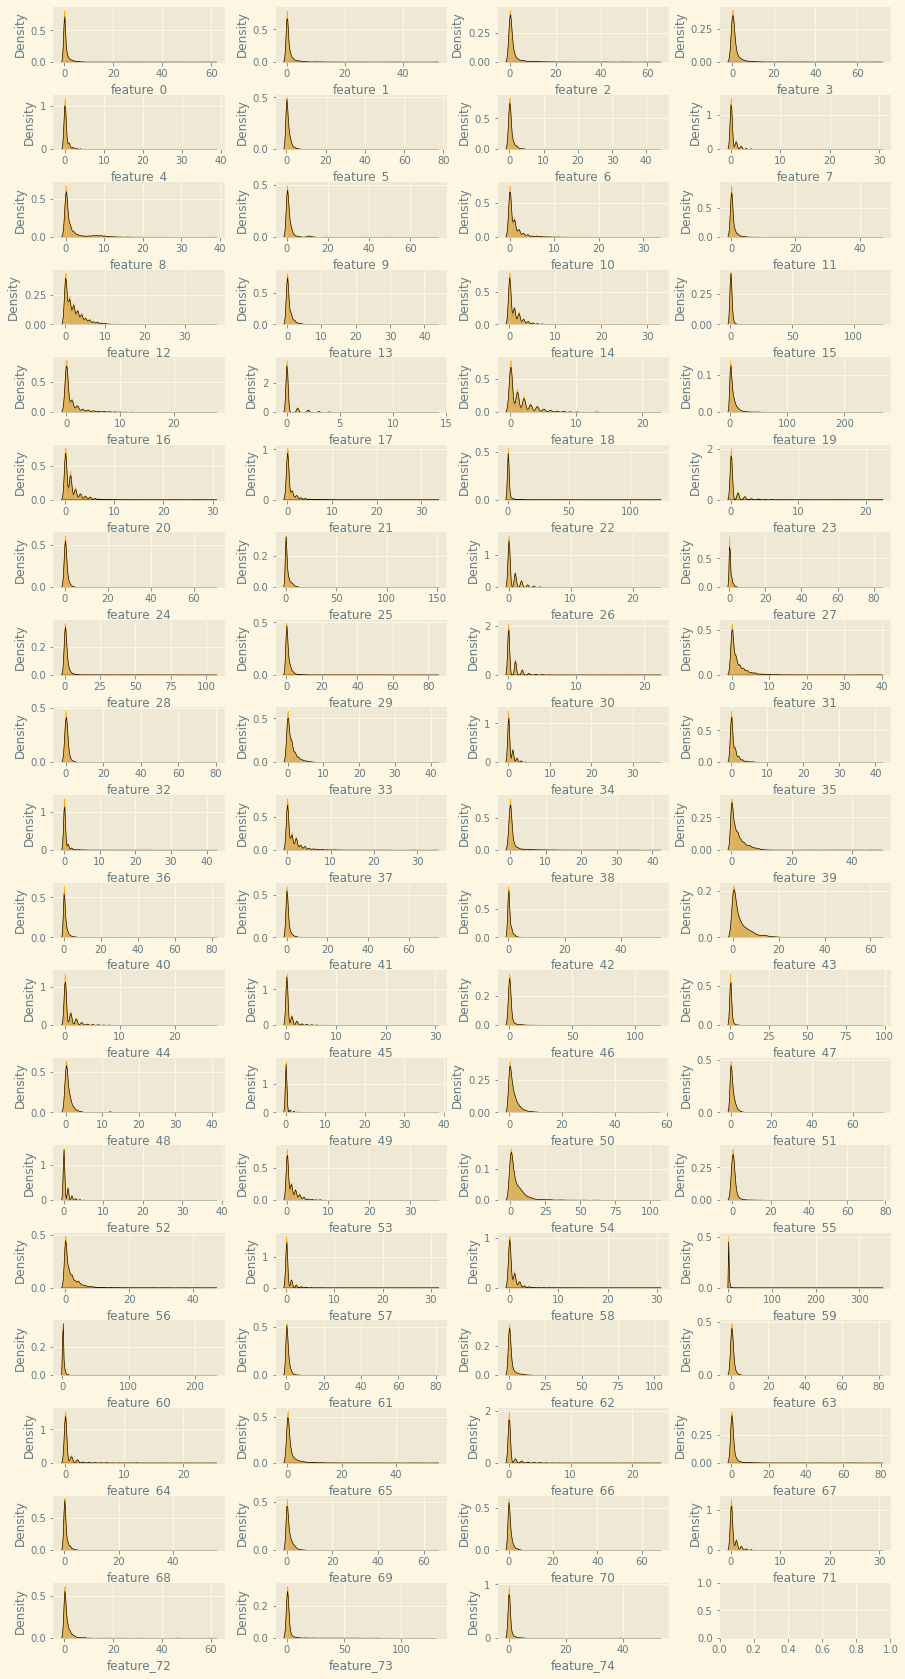

In [ ]:
feature_cols = [col for col in X_train.columns if col != "target"]

plt.style.use("Solarize_Light2")
print(f"Orange is train, and black is test data.")

fig, axes = plt.subplots(19, 4, figsize=(15, 30), gridspec_kw=dict(wspace=0.3, hspace=0.6))
for col, ax in zip(feature_cols, axes.flatten()):
    
    sns.kdeplot(x=df_train[col], ax=ax, alpha=0.5, fill=True, linewidth=0.6, color='orange')
    sns.kdeplot(x=X_test[col], ax=ax, alpha=0.1, fill=True, linewidth=0.6, color='black')

# Target классификации train

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count plot for target of train data')

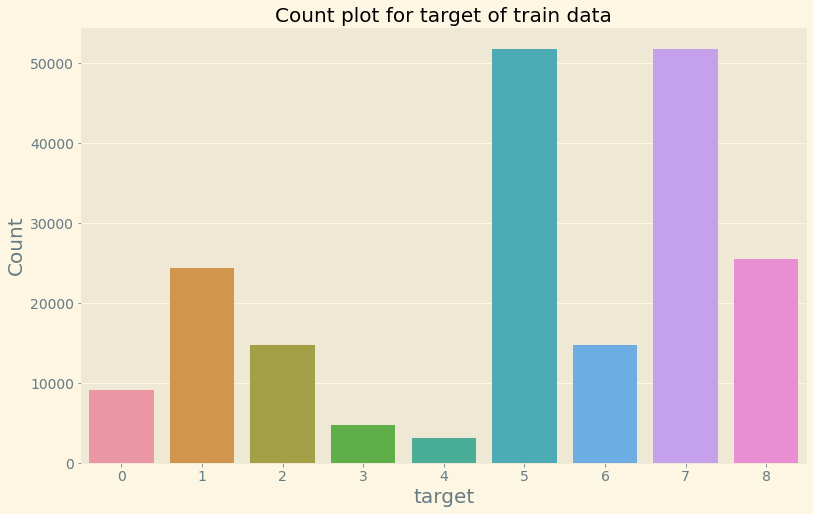

In [ ]:
plt.figure(figsize=(13, 8))
g = sns.countplot(y_train)
g.tick_params(labelsize=14)
g.set_xlabel("target",fontsize=20)
g.set_ylabel("Count",fontsize=20)
g.set_title("Count plot for target of train data",fontsize=20)

# Создание нейронных сетей с помощью библиотеки keras

In [ ]:
def get_model(X_train, n_classes = 9):
    inputs = layers.Input(shape = (X_train.shape[1],)) #слой входных данных с размерностью кол-во колонок
    
    embed = layers.Embedding(360, 8)(inputs) #слой преобразующий категорию в вещественный вектор размерности 8
    embed = layers.Flatten()(embed) #cглаживает тензор к виду плоской таблицы
    
    hidden = layers.Dropout(0.2)(embed) #исключает переобучение 
    hidden = tfa.layers.WeightNormalization(layers.Dense(units=128, activation='selu', kernel_initializer="lecun_normal"))(hidden) 
    #полносвязный слой Dense с функцией активации SELU и последующей нормализацией весов 
  
    output = layers.Dropout(0.2)(layers.Concatenate()([embed, hidden])) #объединение(конкатенация embed, hidden)
    output = tfa.layers.WeightNormalization(layers.Dense(units=64, activation='relu'))(output) 
    #полносвязный слой Dense с функцией активации RELU и последующей нормализацией весов

    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden, output])) #объединение(конкатенация embed, hidden, output)
    output = tfa.layers.WeightNormalization(layers.Dense(units=32, activation='elu'))(output) 
    #полносвязный слой Dense с функцией активации ЕLU и последующей нормализацией весов

    output = layers.Dense(n_classes, activation = 'softmax')(output)
    #слой подаёт на выход вероятности

    model = keras.Model(inputs=inputs, outputs=output, name="res_nn_model")
    
    return model

In [ ]:
K.clear_session() #очистка памяти от keras

cce = keras.losses.CategoricalCrossentropy(name = 'cat_crossentr')

## Обучение модели

In [ ]:
OOF_PRED = np.zeros((X_train.shape[0], 9))
TEST_PRED = np.zeros((X_test.shape[0], 9))
N_starts = 3
for i in range(N_starts):
    N = 10
    kf = StratifiedKFold(n_splits=N, shuffle=True, random_state=13 + i)

    for FOLD, (trn_idx, val_idx) in enumerate(kf.split(y_train, y_train)):
        X_tr, y_tr = X_train.iloc[trn_idx, :], Y_train[trn_idx, :]
        X_val, y_val = X_train.iloc[val_idx, :], Y_train[val_idx, :]

        K.clear_session()
        model = get_model(X_tr)
        model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
                      metrics=custom_metric)

        early_stopping = callbacks.EarlyStopping(patience=10, min_delta=1e-5, restore_best_weights=True)
        plateau = callbacks.ReduceLROnPlateau(factor = 0.7, patience = 2, verbose = 0) 

        model.fit(X_tr, y_tr,
              batch_size = 256, epochs = 100,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping, plateau],
              verbose = 0)

        pred = model.predict(X_val)
        OOF_PRED[val_idx, :] += pred / N_starts
        TEST_PRED += model.predict(X_test) / N / N_starts

        nn_logloss = log_loss(y_train[val_idx], pred)

        print(f"START {i:d} FOLD {FOLD:d}: logloss score {nn_logloss:.6f}")

        del model
        _ = gc.collect()

nn_logloss = log_loss(y_train, OOF_PRED)
print(f"full logloss score {nn_logloss}")

START 0 FOLD 0: logloss score 1.750818
START 0 FOLD 1: logloss score 1.742868
START 0 FOLD 2: logloss score 1.747622
START 0 FOLD 3: logloss score 1.743008
START 0 FOLD 4: logloss score 1.747240
START 0 FOLD 5: logloss score 1.741220
START 0 FOLD 6: logloss score 1.739143
START 0 FOLD 7: logloss score 1.739708
START 0 FOLD 8: logloss score 1.736772
START 0 FOLD 9: logloss score 1.745042
START 1 FOLD 0: logloss score 1.740489
START 1 FOLD 1: logloss score 1.739044
START 1 FOLD 2: logloss score 1.743776
START 1 FOLD 3: logloss score 1.746825
START 1 FOLD 4: logloss score 1.741826
START 1 FOLD 5: logloss score 1.751083
START 1 FOLD 6: logloss score 1.738810
START 1 FOLD 7: logloss score 1.741724
START 1 FOLD 8: logloss score 1.745539
START 1 FOLD 9: logloss score 1.746469
START 2 FOLD 0: logloss score 1.740704
START 2 FOLD 1: logloss score 1.752487
START 2 FOLD 2: logloss score 1.743220
START 2 FOLD 3: logloss score 1.737589
START 2 FOLD 4: logloss score 1.739747
START 2 FOLD 5: logloss s

## На [Kaggle](https://www.kaggle.com/c/tabular-playground-series-jun-2021/leaderboard) score на Colab 1.74562.
## 23.06.2021 это 167 место из 948 (неплохой результат!).
## Далее нейронную сеть вкладываем между двух моделей LightAutoML.
NN_LightAutoML.ipynb

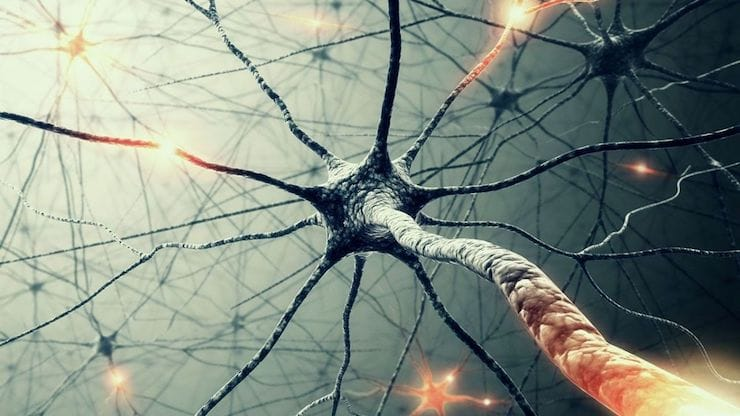

### Прогнозы

In [ ]:
sub = pd.read_csv('/content/sample_submission.csv')


In [ ]:
sub.iloc[:, 1:] = TEST_PRED


In [ ]:
sub.to_csv('nn_predict.csv', index = False)

In [ ]:
oof_preds_df = pd.DataFrame(OOF_PRED, columns = ['Class_' + str(i) for i in range(1, 10)]) 
oof_preds_df.insert(0, 'id', list(range(oof_preds_df.shape[0])))


In [ ]:
oof_preds_df.to_csv('/content/OOF_nn_predict.csv', index = False)